#<center>Программа для определения риска инфаркта миокарда по индивидуальным особенностям пациента</center>

#Бизнес-постановка задачи

Разработка программы для определения риска инфаркта миокарда на основе индивидуальных особенностей пациентов. Такой инструмент повышает эффективность медицинской практики и сокращает расходы медицинских учреждений, а также позволяет людям с риском инфаркта получить заблаговременную помощь и лечение.

#Постановка ML-задачи (бинарная классификация)

В рамках данной задачи классы будут представлены двумя возможными значениями: "Высокий риск инфаркта" и "Низкий риск инфаркта".

#Набор данных:

Набор данных представлен в файле "Dataset.csv". Взят [здесь](https://www.kaggle.com/datasets/alexteboul/heart-disease-health-indicators-dataset).

Изначальный датасет содержал 260+ тысяч строк и ~20 определяющих признаков (все столбцы, помимо "HeartDiseaseorAttack", - это определеямый признак). Для нашего исследования достаточно 2+ тысяч строк (я оставил 10 тысяч). Также количесвто определяющих признаков было сокращено до 12 наиболее важных. Итоговый набор данных представляет из себя таблицу 10000 на 12 (ID, 1 определяемый фактор и 11 определяющих) без учёта нумерации строк и названий столбцов.

In [62]:
import pandas as pd

In [63]:
file_path = 'Dataset.csv'
data = pd.read_csv(file_path, delimiter=';', skipinitialspace=True)
data

,HeartDiseaseorAttack,HighBP,HighChol,BMI,Smoker,Stroke,Diabetes,PhysActivity,HvyAlcoholConsump,DiffWalk,Sex,Age
0,0.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0
1,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,7.0
2,0.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0
3,0.0,1.0,0.0,27.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.0
4,0.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.0,1.0,36.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,9.0
9996,0.0,0.0,0.0,33.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,6.0
9997,0.0,0.0,0.0,26.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,8.0
9998,0.0,0.0,0.0,29.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,7.0


#Пояснения к датасету

Пояснения даны простым языком. Анамнез - история заболеваний и обращений за медицнской помощью.

HeartDiseaseorAttack – наличие инфаркта миокарда (сердечного приступа) у пациента в анамнезе (1.0 – да, 0.0 – нет)

HighBP – наличие повышенного кровяного давления у пациента (1.0 – да, 0.0 – нет)

HighChol – наличие повышенного холестерина у пациента (1.0 – да, 0.0 – нет)

BMI – индекс массы тела пациента

Smoker – пациент за жизнь выкурил как минимум 100 сигарет (1.0 – да, 0.0 – нет)

Stroke – у пациента был инсульт (1.0 – да, 0.0 – нет)

Diabetes – 2.0 – у пациента диабет, 1.0 – у пациента предиабет, 0.0 – у пациента нет диабета

PhysActivity – в повседневной жизни пациента имеется хотя бы небольшая физическая активность (1.0 – да, 0.0 – нет)

HvyAlcoholConsump – пациент выпивает 14 или более бокалов алкогольных напитков в неделю (1.0 – да, 0.0 – нет)

DiffWalk – в последнее время или на постоянной основе у пациента наблюдаются трудности с ходьбой и поднятием по лестнице (1.0 – да, 0.0 – нет)

Sex – пол пациента (1.0 – мужчина, 0.0 – женщина)

Age – индекс возраста пациента. Каждому индексу от 1 до 13 соответствует диапазон возрастов в годах от минимального (включительно) до максимального (включительно). Для более простого определения представлена таблица "age.csv".


In [65]:
df = pd.read_csv('age.csv', delimiter=';', na_values=['NaN'])
df.index = df.index + 1
df

,"Min, years","Max, years"
1,18,24.0
2,25,29.0
3,30,34.0
4,35,39.0
5,40,44.0
6,45,49.0
7,50,54.0
8,55,59.0
9,60,64.0
10,65,69.0


#Метрика для измерения качества

Для задачи определения риска инфаркта миокарда у пациентов, наиболее релевантной метрикой будет ROC-AUC. Эта метрика позволяет оценить способность модели разделять классы, учитывая баланс между чувствительностью и специфичностью. Для прогнозирования рисков инфаркта миокарда важно минимизировать как ложные положительные, так и ложные отрицательные результаты. ROC-AUC как раз отражает этот баланс.

#EDA

Рассмотрим базовые характеристики нашего датасета. Все они изначально весьма качественно приведены к общему виду. Пропуски отсутствуют. Числовые данные указываются в формате float64, что в дальнейшем, возможно, немного упростит работу с данными.

In [ ]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   HeartDiseaseorAttack  10000 non-null  float64
 1   HighBP                10000 non-null  float64
 2   HighChol              10000 non-null  float64
 3   BMI                   10000 non-null  float64
 4   Smoker                10000 non-null  float64
 5   Stroke                10000 non-null  float64
 6   Diabetes              10000 non-null  float64
 7   PhysActivity          10000 non-null  float64
 8   HvyAlcoholConsump     10000 non-null  float64
 9   DiffWalk              10000 non-null  float64
 10  Sex                   10000 non-null  float64
 11  Age                   10000 non-null  float64
dtypes: float64(12)
memory usage: 937.6 KB
None


Рассмотрим базовую статистику нашего датасета

In [ ]:
print(data.describe())

       HeartDiseaseorAttack        HighBP      HighChol           BMI  \
count          10000.000000  10000.000000  10000.000000  10000.000000   
mean               0.101000      0.462500      0.449400     28.576600   
std                0.301344      0.498617      0.497458      6.330651   
min                0.000000      0.000000      0.000000     14.000000   
25%                0.000000      0.000000      0.000000     24.000000   
50%                0.000000      0.000000      0.000000     27.000000   
75%                0.000000      1.000000      1.000000     32.000000   
max                1.000000      1.000000      1.000000     74.000000   

             Smoker        Stroke      Diabetes  PhysActivity  \
count  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.451300      0.046900      0.339000      0.743300   
std        0.497648      0.211435      0.738467      0.436834   
min        0.000000      0.000000      0.000000      0.000000   
25%        0.0000

Наиболее важные выводы из результатов анализа:
1. 10,1% из выборки имеют в анамнезе инфаркт миокарда
2. 46,25% из выборки имеют повышенное кровяное давление
3. 44,94% из выборки имеют повышенный холестерин
4. Большая часть людей из выборки имеет повышенный вес
5. 45,13% из выборки выкурили не менее 100 сигарет за жизнь
6. 4,69% из выборки имеют в анамнезе инсульт
7. 74,33% из выборки регулярно имеют хотя бы минимальный уровень физической активности
8. 5,52% из выборки употребляют 14 и более алкогольных напитков в неделю
9. 19,56% из выборки испытывают проблемы при ходьбе
10. 41,77% из выборки - мужчины, 58,23% - женщины.

Столбцы, полученные данные о которых не имеют логически приемлимой интерпритации: Diabetes, Age

Из процентных соотношений видно, что выборка релевантна и в ней имеется достатчно количество людей с различными факторами риска для обучения ИИ.

#Визуализация

Построим наиболее релевантные графики, а также графики тех столбцов, результаты анализа которых интерпритировать не удалось.

#Диабет

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

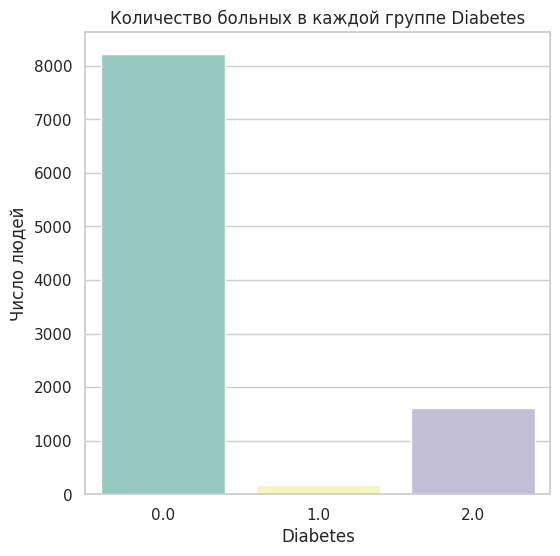

In [7]:
sns.set(style="whitegrid")
plt.figure(figsize=(6, 6))

diabetes_counts = data['Diabetes'].value_counts()

sns.countplot(x='Diabetes', data=data, palette="Set3")

plt.xticks(ticks=[0, 1, 2], labels=['0.0', '1.0', '2.0'])

plt.ylabel('Число людей')

plt.title('Количество больных в каждой группе Diabetes')

plt.show()

Данный график даёт нам возможность оценить данные по больным диабетом. Как видно из графика более 8 тысяч из 10 в нашей выборке не страдают диабетом. Около 1.5 тысяч людей страдают диабетом первого и второго типа. И мизерная часть - около 100-200 людей находится в преддиабетном состоянии. Данное распределение весьма близко к распределению по миру (~10% больных дибаетом, 1-2% в преддиабетном состоянии), что говорит о релевантности нашей выборки.

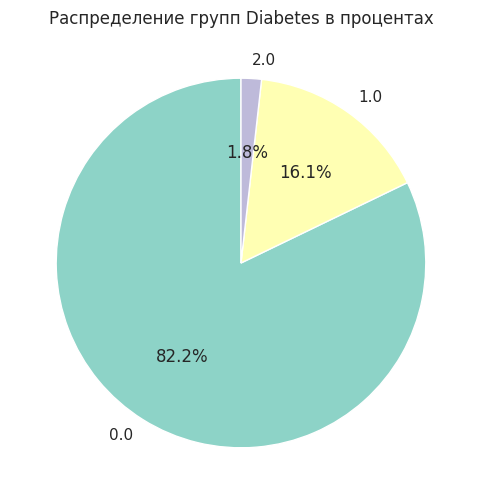

In [9]:
file_path = 'Dataset.csv'
data = pd.read_csv(file_path, delimiter=';', skipinitialspace=True)

diabetes_counts = data['Diabetes'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(diabetes_counts, labels=['0.0', '1.0', '2.0'], autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set3"))

plt.title('Распределение групп Diabetes в процентах')

plt.show()

#Возрастные группы

In [29]:
import plotly.express as px

file_path = 'Dataset.csv'
data = pd.read_csv(file_path, delimiter=';', skipinitialspace=True)

age_counts = data['Age'].value_counts()

fig = px.pie(names=age_counts.index, values=age_counts)

fig.update_layout(title_text='Доли возорастных групп в выборке', title_x=0.5, title_y=0.98)

fig.show()

На диаграмме видно, что более 50% людей находятся в восьмой и выше возрастных группах, что соответтвует возрастам в 60 лет и выше. Это распределение обусловлено тем, что данные собирались в медицинских учреждениях, которые, по ряду очевидных причин, чаще посещают люди в возрасте, нежели молодые люди.

#Частоты инфаркта миокарда среди мужчин и женщин в выборке

In [34]:
file_path = 'Dataset.csv'
data = pd.read_csv(file_path, delimiter=';', skipinitialspace=True)

data.rename(columns={'HeartDiseaseorAttack': 'HeartAttack'}, inplace=True)

data['Sex'] = data['Sex'].replace({1.0: 'Мужчины', 0.0: 'Женщины'})

fig = px.histogram(data, x='Sex', color='HeartAttack', barmode='group', labels={'Sex': 'Пол', 'HeartAttack': 'Инфаркт'})

fig.update_layout(xaxis_title='Пол', yaxis_title='Число людей', title='Частота инфаркта у мужчин и женщин', title_x=0.5, title_y=0.98)

fig.show()


Диаграмма наглядно иллюстрирует, что в рамках выборки доля женщин, имеющих в анамнезе инфаркт миокарда меньше, чем доля таковых мужчин примерно в полтора раза (~1:11 против ~1:7). Это, в целом, соответсвует данным более обширных исследований и объясняется рядом причин: гормональные различия, работа различной тяжести и опасности, различия в поведении и стиле жизни и т.д. Также это является одной из причин более известной статистики - средняя продолжительность жизни женщин выше, чем таковая у мужчин.

#Зависимость частоты инфаркта миокарда от наличия высокого кровяного давления в выборке

In [56]:
file_path = 'Dataset.csv'
data = pd.read_csv(file_path, delimiter=';', skipinitialspace=True)

data.rename(columns={'HeartDiseaseorAttack': 'HeartAttack'}, inplace=True)

data['HighBP'] = data['HighBP'].replace({1.0: 'Высокое кровяное давление', 0.0: 'Отсутствие высокого кровяного давления'})

fig = px.histogram(data, x='HighBP', color='HeartAttack', barmode='group', labels={'HighBP': 'Высокое кровяное давление', 'HeartAttack': 'Инфаркт'})

fig.update_layout(xaxis_title='', yaxis_title='Число людей', title='Частота инфаркта среди людей с высоким и низким давлением', title_x=0.5, title_y=0.98)

fig.show()

Output hidden; open in https://colab.research.google.com to view.

Видно, что в рамках выборки доля людей с высоким кровяным давлением намного чаще имеет в анамнезе инфаркт миокарда, нежели доля людей с отсутствием высокого кровяного давления. Это соответсвует результатам более обширных исследований и иллюстрирует известный медицинский факт о том, что высокое кровяное давление - одна из наиболее частых причин инфаркта миокарда.

#Зависимость доли людей с инфарктом миокарда в анамнезе от возрастной группы в выборке

In [55]:
file_path = 'Dataset.csv'
data = pd.read_csv(file_path, delimiter=';', skipinitialspace=True)

age_groups = data.groupby('Age')['HeartDiseaseorAttack'].mean().reset_index()

fig = px.bar(age_groups, x='Age', y='HeartDiseaseorAttack',
             labels={'Age': 'Возрастная группа', 'HeartDiseaseorAttack': 'Доля людей с инфарктом'},
             title='Доля людей с инфарктом миокарда в анамнезе в каждой возрастной группе',
             category_orders={'HeartDiseaseorAttack': [0.0, 1.0]},
             height=400)

fig.update_layout(xaxis_title='Возрастная группа', yaxis_title='Доля людей с инфарктом')

fig.update_layout(title_x=0.5)

fig.show()


Диаграмма показывет, что с увеличением номера возрастной группы (и, соответсвенно, увеличением возраста) в выборке доля людей с инфарктом миокарда в анамнезе возрастает - от 0% в группе 1 (от 18 до 24 лет) до >25% в группе 13 (80 лет и более). Исходя из таблицы можно сделать осторожное предположение о том, что этот рост - экспоненциальный